# Data Fit (Neural Networks): SIR data with noise
## Additional architectures

**Purpose:** Benchmark different NN architectures on **noisy datasets**.

* Tests multiple models (CNNs, deeper MLPs, etc.) under noisy conditions.
* Compares robustness of architectures against noise.
* Reports performance trade-offs: accuracy vs complexity.
* Includes plots of predictions vs true parameters under different levels of noise.

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-06-25 13:20:04.851423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 13:20:04.866918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750872004.885479   35948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750872004.891742   35948 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750872004.906439   35948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


## Load data 

In [3]:
# Load Simulated data
import pickle as pkl
data_path = '../../data/raw/simulated/SIR'
with open(f'{data_path}/sir.pkl', 'rb') as f:
    data_sim = pkl.load(f) 

## Division Training/Validation/Test

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X = [] # X will be the data from infected people
y = [] # y will be the parameters from that simulation

for simulation in data_sim:
    compartment_data = simulation[0]  # S, I, R matrix
    parameters = simulation[2]  # [beta, gamma]
    
    # Extract I values
    I_values = compartment_data[:, 1]  # second column columna (I compartment)
    
    X.append(I_values)  # Add to the characteristic list
    y.append(parameters)  # Add to label list

# Convert to numpy arrays
X = np.array(X) 
y = np.array(y) 

# First division: 99% training + validation, 1% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Second división: 80% training, 20% validation. 
# General split: 79.2% training, 19.8% validation, 1% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Adding noise
for i, x in enumerate(X_test):
    # Add Gaussian noise (small)
    noise_std = np.mean(x)  # mean value
    noise = np.random.normal(0, noise_std, size=x.shape)
    X_test[i] = x + noise

# Imprimir formas para verificar
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (79200, 1001)
X_val shape: (19800, 1001)
X_test shape: (1000, 1001)
y_train shape: (79200, 2)
y_val shape: (19800, 2)
y_test shape: (1000, 2)


# SIR simulation for signal comparison

In [5]:
import numpy as np
from summer import CompartmentalModel

# Function to simulate the SIR model given beta and gamma
def simulate_SIR(beta, gamma, times=[0, 100], S0=90, I0=10):
    model = CompartmentalModel(
        times=times,
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": S0, "I": I0})
    model.add_infection_frequency_flow("infection", contact_rate=beta, source="S", dest="I")
    model.add_transition_flow("recovery", fractional_rate=gamma, source="I", dest="R")
    model.run()
    return model.outputs.T[1] # Infected compartment

# 1. CNN-1D

In [28]:
%%time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Conv1D, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.activations import swish
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import R2Score

# Build the model
model_cnn1d = Sequential([
    InputLayer(input_shape=(1001,)),  # Input is a 1D vector
    Reshape((1001, 1)),               # Reshape to (time_steps, channels) for Conv1D
    Conv1D(filters=128, kernel_size=5, activation=swish, padding='same'),  # Local patterns
    Conv1D(filters=64, kernel_size=9, activation=swish, padding='same'),  # Finer detail
    Flatten(),         # Aggregate features across the time axis
    Dense(12, activation=swish),    # Dense processing
    Dense(64, activation=swish),    # Dense processing
    Dense(2, activation='linear')     # Output: [beta, gamma]
])

# Compile the model
model_cnn1d.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss=Huber(delta=1e-4),
    metrics=[R2Score()]
)

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_r2_score", patience=15, restore_best_weights=True)

# Train the model
history_cnn1d = model_cnn1d.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 8.0018e-06 - r2_score: 0.8175 - val_loss: 2.4644e-06 - val_r2_score: 0.9896
Epoch 2/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 2.7519e-06 - r2_score: 0.9887 - val_loss: 2.6017e-06 - val_r2_score: 0.9915
Epoch 3/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.5590e-06 - r2_score: 0.9910 - val_loss: 1.8443e-06 - val_r2_score: 0.9941
Epoch 4/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.2579e-06 - r2_score: 0.9926 - val_loss: 1.4056e-06 - val_r2_score: 0.9956
Epoch 5/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 2.1785e-06 - r2_score: 0.9929 - val_loss: 1.8344e-06 - val_r2_score: 0.9946
Epoch 6/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 2.0099e-06 - r2_score: 0.9937 - val_loss: 1.6612e-06 - val_r2_score: 0.9945
Epoch 7/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 1.8973e-06 - r2_score: 0.9942 - val_loss: 1.9539e-06 - val_r2_score: 0.9966
Epoch 8/100
2475/247

In [29]:
model_cnn1d.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - r2_score: -11223.7861


[0.0017125977901741862, -10870.66015625]

In [8]:
y_pred_cnn1d = model_cnn1d.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [9]:
# saving model
model_cnn1d.save("../../models/sir_cnn1dNN_noise.h5")

In [10]:
from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred_cnn1d, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: -717.284602348667


In [11]:
# Save Params fitted
with open(f'{data_path}/test/sir_params_fit_cnn1dNN_noise.pkl', 'wb') as f:
    pkl.dump(y_pred_cnn1d, f)

## Visual examples: estimated parameters vs real parameters.

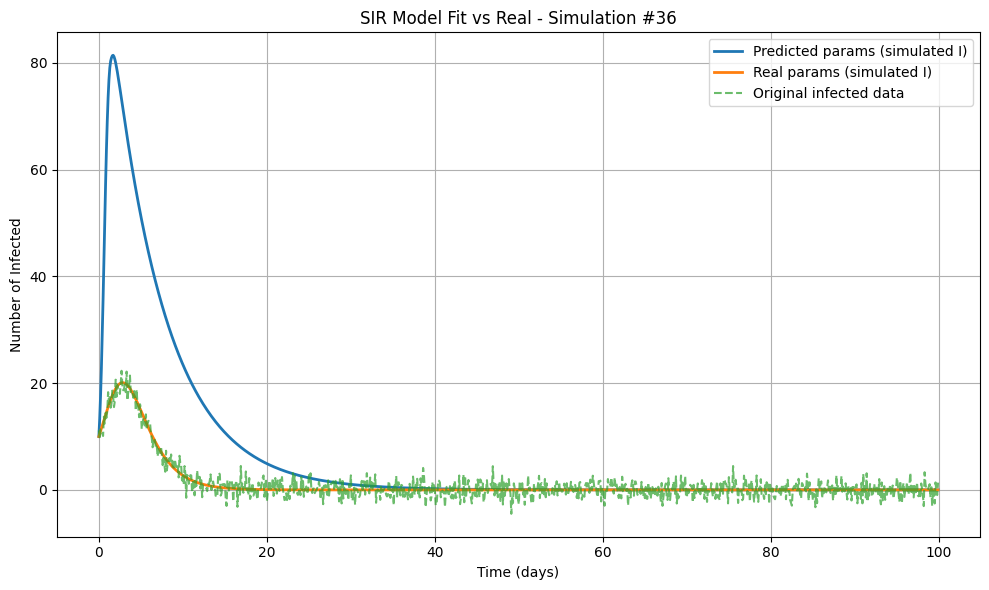

In [12]:
import matplotlib.pyplot as plt

# Example: simulation index to visualize
n_sim = 36

# True parameters
beta_real, gamma_real = y_test[n_sim]
# Estimated parameters
beta_pred, gamma_pred = y_pred_cnn1d[n_sim]

# Simulate using real and predicted parameters
solution_real_fit = simulate_SIR(beta_real, gamma_real)
solution_pred_fit = simulate_SIR(beta_pred, gamma_pred)

# Extract infected curves
I_real_model = solution_real_fit  # simulate_SIR returns only I
I_pred_model = solution_pred_fit
I_data = X_test[n_sim, :]  # Infected values from simulation (ground truth)

# Time vector (assume same as in model)
t = np.linspace(0, 100, len(I_data))
n_points = min(len(t), 1000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:n_points], I_pred_model[:n_points], '-', label='Predicted params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_real_model[:n_points], '-', label='Real params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_data[:n_points], '--', label='Original infected data', alpha=0.7)
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected')
plt.title(f'SIR Model Fit vs Real - Simulation #{n_sim}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\beta_{real}$ vs $\beta_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


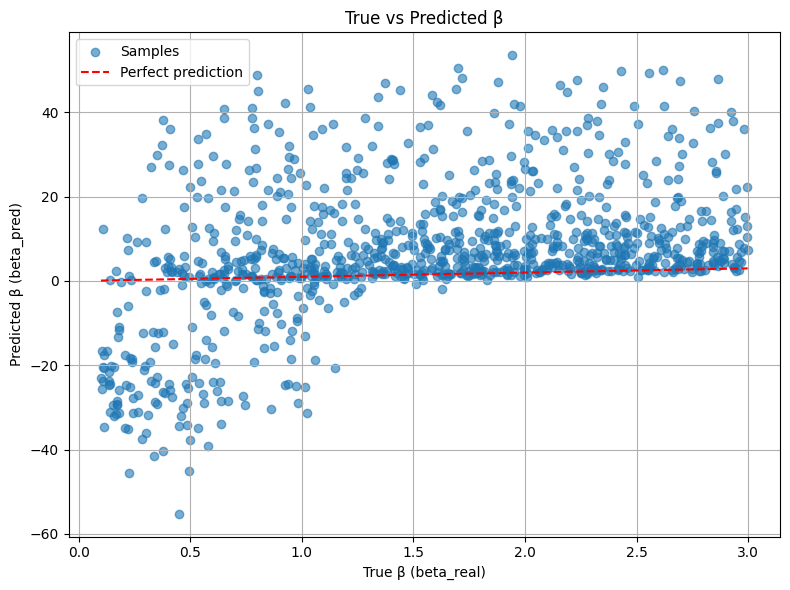

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract beta from predictions and true values
beta_real = y_test[:, 0]
beta_pred = model_cnn1d.predict(X_test)[:, 0]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(beta_real, beta_pred, alpha=0.6, label='Samples')
plt.plot([beta_real.min(), beta_real.max()], [beta_real.min(), beta_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True β (beta_real)')
plt.ylabel('Predicted β (beta_pred)')
plt.title('True vs Predicted β')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\gamma_{real}$ vs $\gamma_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


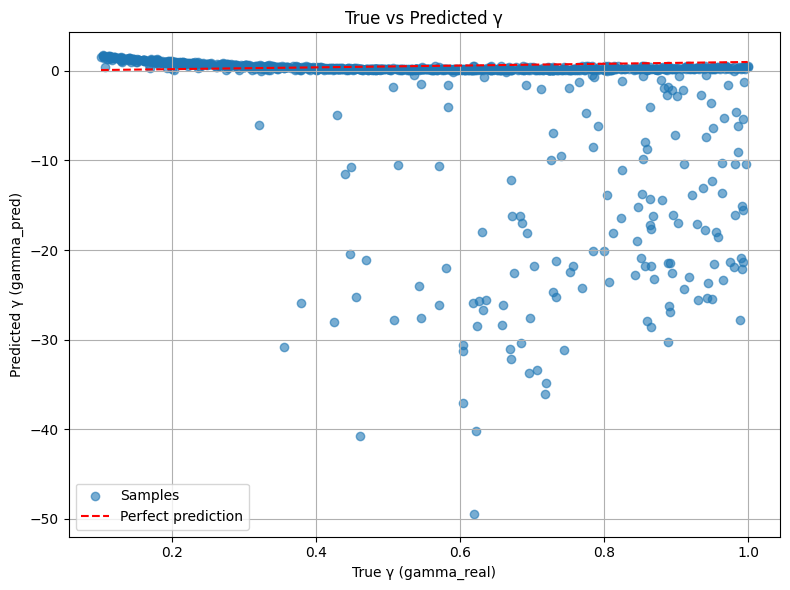

In [14]:
import matplotlib.pyplot as plt

# Extract gamma from predictions and true values
gamma_real = y_test[:, 1]
gamma_pred = model_cnn1d.predict(X_test)[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(gamma_real, gamma_pred, alpha=0.6, label='Samples')
plt.plot([gamma_real.min(), gamma_real.max()],
         [gamma_real.min(), gamma_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True γ (gamma_real)')
plt.ylabel('Predicted γ (gamma_pred)')
plt.title('True vs Predicted γ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. CNN-1D Branched

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.callbacks import EarlyStopping

# Input layer
inputs = Input(shape=(1001,), name="input_signal")
x = Reshape((1001, 1), name="reshape_to_cnn")(inputs)

# Shared convolutional base
x = Conv1D(filters=64, kernel_size=9, activation=swish, padding='same', name="conv1")(x)
x = Conv1D(filters=64, kernel_size=5, activation=swish, padding='same', name="conv2")(x)
x = GlobalAveragePooling1D(name="global_avg_pool")(x)
x = Dense(64, activation=swish, name="shared_dense")(x)

# Branch for beta
b = Dense(32, activation=swish, name="beta_dense1")(x)
b = Dense(16, activation=swish, name="beta_dense2")(b)
b = Dense(1, activation='linear', name="beta_output")(b)

# Branch for gamma
g = Dense(32, activation=swish, name="gamma_dense1")(x)
g = Dense(16, activation=swish, name="gamma_dense2")(g)
g = Dense(1, activation='linear', name="gamma_output")(g)

# Final model
outputs = tf.keras.layers.Concatenate(name="final_output")([b, g])
model_cnn1d_branched = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_cnn1d_branched.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss=Huber(delta=1e-4),
    metrics=[R2Score()]
)

# Early stopping
early_stopping = EarlyStopping(monitor="val_r2_score", patience=15, restore_best_weights=True)

# Train the model
history_cnn1d_branched = model_cnn1d_branched.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 1.9689e-05 - r2_score: 0.5747 - val_loss: 2.9360e-06 - val_r2_score: 0.9809
Epoch 2/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.2469e-06 - r2_score: 0.9829 - val_loss: 2.9979e-06 - val_r2_score: 0.9869
Epoch 3/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.4926e-06 - r2_score: 0.9888 - val_loss: 1.7933e-06 - val_r2_score: 0.9929
Epoch 4/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.0688e-06 - r2_score: 0.9921 - val_loss: 1.9279e-06 - val_r2_score: 0.9925
Epoch 5/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.7973e-06 - r2_score: 0.9935 - val_loss: 1.8311e-06 - val_r2_score: 0.9960
Epoch 6/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.6440e-06 - r2_score: 0.9947 - val_loss: 1.2473e-06 - val_r2_score: 0.9954
Epoch 7/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.4380e-06 - r2_score: 0.9955 - val_loss: 1.3556e-06 - val_r2_score: 0.9948
Epoch 8/100
2475/2475 ━━━━

In [16]:
model_cnn1d_branched.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029 - r2_score: -28860.8770


[0.0030820828396826982, -30955.189453125]

In [17]:
y_pred_cnn1d_br = model_cnn1d_branched.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [18]:
# saving model
model_cnn1d_branched.save("../../models/sir_cnn1dbranchedNN_noise.h5")

In [19]:
from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred_cnn1d_br, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: -30955.17728047333


In [20]:
# Save Params fitted
with open(f'{data_path}/test/sir_params_fit_cnn1dbranchedNN_noise.pkl', 'wb') as f:
    pkl.dump(y_pred_cnn1d_br, f)

## Visual examples: estimated parameters vs real parameters.

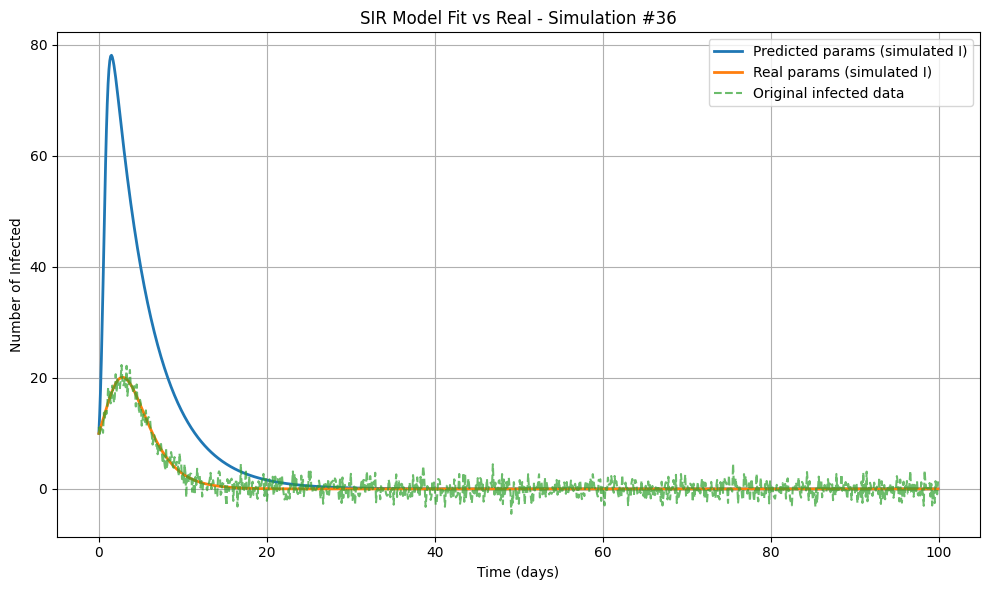

In [21]:
import matplotlib.pyplot as plt

# Example: simulation index to visualize
n_sim = 36

# True parameters
beta_real, gamma_real = y_test[n_sim]
# Estimated parameters
beta_pred, gamma_pred = y_pred_cnn1d_br[n_sim]

# Simulate using real and predicted parameters
solution_real_fit = simulate_SIR(beta_real, gamma_real)
solution_pred_fit = simulate_SIR(beta_pred, gamma_pred)

# Extract infected curves
I_real_model = solution_real_fit  # simulate_SIR returns only I
I_pred_model = solution_pred_fit
I_data = X_test[n_sim, :]  # Infected values from simulation (ground truth)

# Time vector (assume same as in model)
t = np.linspace(0, 100, len(I_data))
n_points = min(len(t), 1000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:n_points], I_pred_model[:n_points], '-', label='Predicted params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_real_model[:n_points], '-', label='Real params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_data[:n_points], '--', label='Original infected data', alpha=0.7)
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected')
plt.title(f'SIR Model Fit vs Real - Simulation #{n_sim}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\beta_{real}$ vs $\beta_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


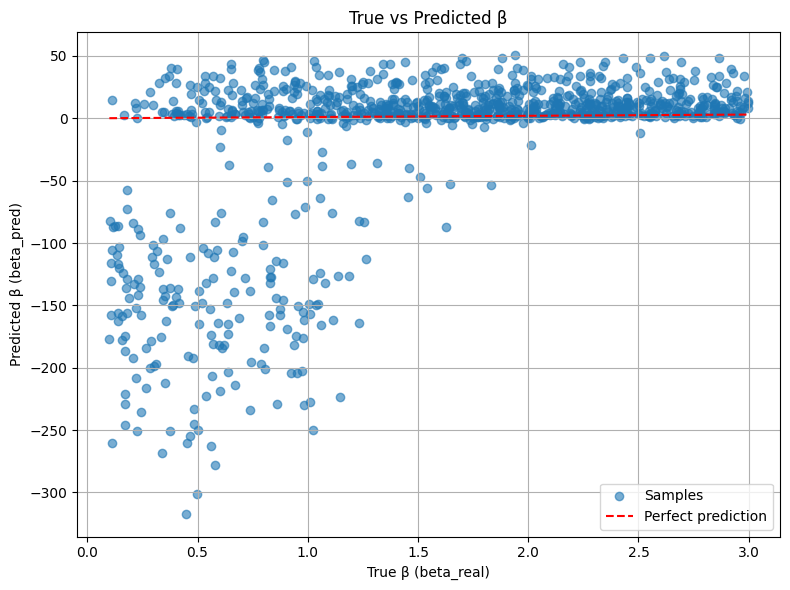

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extract beta from predictions and true values
beta_real = y_test[:, 0]
beta_pred = model_cnn1d_branched.predict(X_test)[:, 0]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(beta_real, beta_pred, alpha=0.6, label='Samples')
plt.plot([beta_real.min(), beta_real.max()], [beta_real.min(), beta_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True β (beta_real)')
plt.ylabel('Predicted β (beta_pred)')
plt.title('True vs Predicted β')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\gamma_{real}$ vs $\gamma_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


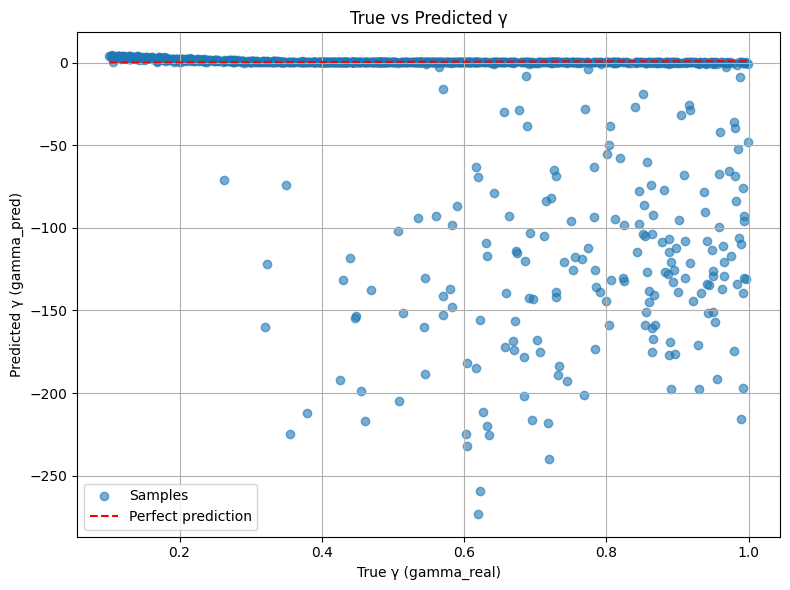

In [23]:
import matplotlib.pyplot as plt

# Extract gamma from predictions and true values
gamma_real = y_test[:, 1]
gamma_pred = model_cnn1d_branched.predict(X_test)[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(gamma_real, gamma_pred, alpha=0.6, label='Samples')
plt.plot([gamma_real.min(), gamma_real.max()],
         [gamma_real.min(), gamma_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True γ (gamma_real)')
plt.ylabel('Predicted γ (gamma_pred)')
plt.title('True vs Predicted γ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()